In [ ]:
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from collections import defaultdict
import tempfile
import shutil

# Dataset configuration
CLASSES = ['cloudy', 'land', 'water']
DATA_DIR = 'data'

class ImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None, is_training=False):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.is_training = is_training
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        
        try:
            image = cv2.imread(image_path)
            if image is None:
                raise ValueError(f"Could not load image: {image_path}")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Resize to 64x64
            image = cv2.resize(image, (64, 64), interpolation=cv2.INTER_CUBIC)
                
        except Exception as e:
            print(f"Error loading {image_path}: {e}")
            # Fallback to black image
            image = np.zeros((64, 64, 3), dtype=np.uint8)
        
        if self.transform:
            if isinstance(self.transform, A.Compose):
                transformed = self.transform(image=image)
                image = transformed['image']
            else:
                image = self.transform(image)
            
        return image, self.labels[idx]

class ImageClassifier(nn.Module):
    def __init__(self, num_classes=3, dropout_rate=0.3):
        super().__init__()
        
        # Simple CNN for 64x64 images
        self.features = nn.Sequential(
            # First conv block
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 32x32
            
            # Second conv block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 16x16
            
            # Third conv block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 8x8
            
            # Fourth conv block
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 4x4
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(512),
            nn.Dropout(dropout_rate * 0.5),
            nn.Linear(512, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

def load_data(data_dir):
    """Load images and labels from directory structure"""
    image_paths = []
    labels = []
    
    print(f"Loading data from {data_dir}...")
    
    for class_idx, class_name in enumerate(CLASSES):
        class_dir = os.path.join(data_dir, class_name)
        
        if not os.path.exists(class_dir):
            print(f"Warning: {class_dir} does not exist")
            continue
            
        valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif')
        class_images = 0
        
        for filename in os.listdir(class_dir):
            if filename.lower().endswith(valid_extensions):
                image_path = os.path.join(class_dir, filename)
                # Quick validation
                test_img = cv2.imread(image_path)
                if test_img is not None:
                    image_paths.append(image_path)
                    labels.append(class_idx)
                    class_images += 1
        
        print(f"  {class_name}: {class_images} images")
    
    print(f"Total: {len(image_paths)} images across {len(set(labels))} classes")
    return image_paths, labels

def get_transforms():
    """Get transforms for 64x64 images"""
    
    train_transform = A.Compose([
        A.Resize(height=64, width=64),
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=15, p=0.3),
        # A.ColorJitter(),
        A.RandomBrightnessContrast(),
        A.HueSaturationValue(),
        A.RGBShift(r_shift_limit=0, g_shift_limit=0, b_shift_limit=90, p=0.8),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])
    
    val_transform = A.Compose([
        A.Resize(height=64, width=64),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])
    
    return train_transform, val_transform

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, 
                device, num_epochs=25, patience=10):
    """Training loop"""
    
    best_val_acc = 0.0
    patience_counter = 0
    best_model_state = None
    history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'lr': []}
    
    print(f"Training on {device}")
    print(f"Training samples: {len(train_loader.dataset)}")
    print(f"Validation samples: {len(val_loader.dataset)}")
    print("-" * 50)
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        
        for images, labels in train_pbar:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            train_acc = train_correct / train_total
            train_pbar.set_postfix({'Loss': f'{loss.item():.4f}', 'Acc': f'{train_acc:.4f}'})
        
        train_loss /= len(train_loader.dataset)
        train_acc = train_correct / train_total
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Valid]')
        
        with torch.no_grad():
            for images, labels in val_pbar:
                images, labels = images.to(device), labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                val_acc = correct / total
                val_pbar.set_postfix({'Acc': f'{val_acc:.4f}'})
        
        val_loss /= len(val_loader.dataset)
        val_acc = correct / total
        
        # Update scheduler
        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        
        # Store history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['lr'].append(current_lr)
        
        print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, LR: {current_lr:.6f}")
        
        # Early stopping check
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            best_model_state = model.state_dict().copy()
            print(f"  → New best validation accuracy: {best_val_acc:.4f}")
        else:
            patience_counter += 1
            print(f"  → No improvement. Patience: {patience_counter}/{patience}")
        
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
        
        print("-" * 50)
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"Loaded best model with validation accuracy: {best_val_acc:.4f}")
    
    return history

def main():
    # Configuration
    config = {
        'batch_size': 30,
        'num_epochs': 50,
        'learning_rate': 1e-3,
        'weight_decay': 1e-4,
        'dropout_rate': 0.3,
        'patience': 20,
    }
    
    # Set device
    if torch.backends.mps.is_available():
        device = torch.device("mps")
    elif torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    
    print(f"Using device: {device}")
    
    # Load data
    image_paths, labels = load_data(DATA_DIR)
    
    if len(image_paths) == 0:
        print("No images found. Check your data directory structure.")
        return
    
    # Split data
    train_paths, temp_paths, train_labels, temp_labels = train_test_split(
        image_paths, labels, test_size=0.4, random_state=42, stratify=labels
    )
    
    val_paths, test_paths, val_labels, test_labels = train_test_split(
        temp_paths, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
    )
    
    print(f"\nData split:")
    print(f"Training: {len(train_paths)} images")
    print(f"Validation: {len(val_paths)} images") 
    print(f"Test: {len(test_paths)} images")
    
    # Get transforms
    train_transform, val_transform = get_transforms()
    
    # Create datasets
    train_dataset = ImageDataset(train_paths, train_labels, train_transform)
    val_dataset = ImageDataset(val_paths, val_labels, val_transform)
    test_dataset = ImageDataset(test_paths, test_labels, val_transform)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], 
                             shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], 
                           shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], 
                            shuffle=False, num_workers=0)
    
    # Initialize model
    model = ImageClassifier(num_classes=len(CLASSES), 
                           dropout_rate=config['dropout_rate'])
    model = model.to(device)
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'], 
                          weight_decay=config['weight_decay'])
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)
    
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    # Train model
    history = train_model(model, train_loader, val_loader, criterion, optimizer, 
                         scheduler, device, config['num_epochs'], config['patience'])
    
    # Save model
    torch.save({
        'model_state_dict': model.state_dict(),
        'classes': CLASSES,
        'config': config,
        'history': history
    }, 'image_classifier_64x64.pth')
    print("Model saved to image_classifier_64x64.pth")

if __name__ == "__main__":
    main()

In [4]:
def test_image(image_path, model_path='image_classifier_64x64.pth', show_plots=True):
    """
    Test a single 64x64 image (or resize to 64x64).
    Simple single-pass classification.
    """
    
    # Set device
    if torch.backends.mps.is_available():
        device = torch.device("mps")
    elif torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    
    # Load model
    checkpoint = torch.load(model_path, map_location=device)
    model = ImageClassifier(num_classes=len(CLASSES))
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    
    # Load and preprocess image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not load image: {image_path}")
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_image = image.copy()
    
    # Get validation transform
    _, val_transform = get_transforms()
    
    # Transform image
    image_tensor = val_transform(image=image)['image'].unsqueeze(0).to(device)
    
    # Predict
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probabilities, 1)
        
        pred_class = CLASSES[predicted.item()]
        conf_score = confidence.item()
        all_probs = probabilities.cpu().numpy()[0]
    
    if show_plots:
        print(f"Predicted Class: {pred_class}")
        print(f"Confidence: {conf_score:.4f}")
        print(f"All probabilities: {dict(zip(CLASSES, all_probs))}")
        
        # Show image
        plt.figure(figsize=(8, 6))
        plt.imshow(original_image)
        plt.title(f"Prediction: {pred_class} (Confidence: {conf_score:.3f})")
        plt.axis('off')
        plt.show()
    
    return pred_class, conf_score

def test_large_image(image_path, tile_size=64, overlap=0.0, confidence_threshold=0.5, 
                     model_path='image_classifier_64x64.pth', visualize=True, darkness_threshold=30):
    """
    Test a large image by dividing it into tiles and running test_image on each tile.
    If a tile is too dark, classify it as space instead.
    """
    
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not load image: {image_path}")
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_image = image.copy()
    h, w = image.shape[:2]
    
    step_size = int(tile_size * (1 - overlap))
    
    # Data structures for analysis
    class_counts = defaultdict(int)
    class_confidences = defaultdict(list)
    tile_details = []
    
    # Define colors for visualization
    class_colors = {
        'cloudy': (255, 150, 150),
        'land': (150, 255, 150),    
        'water': (150, 150, 255),
        'space': (50, 50, 50)  # Dark gray for space
    }
    
    print(f"Processing {h}x{w} image with {tile_size}x{tile_size} tiles...")
    print(f"Darkness threshold: {darkness_threshold} (tiles darker than this will be classified as space)")
    
    # Create temporary directory for tile images
    temp_dir = tempfile.mkdtemp()
    
    try:
        total_tiles = 0
        confident_tiles = 0
        
        for y in range(0, h - tile_size + 1, step_size):
            for x in range(0, w - tile_size + 1, step_size):
                total_tiles += 1
                
                # Extract tile
                tile = image[y:y+tile_size, x:x+tile_size]
                
                # Check if tile is too dark
                mean_brightness = np.mean(tile)
                
                if mean_brightness < darkness_threshold:
                    # Classify as space
                    tile_class = 'space'
                    tile_confidence = 1.0  # High confidence for space classification
                    confident_tiles += 1
                    class_counts[tile_class] += 1
                    class_confidences[tile_class].append(tile_confidence)
                    tile_details.append((x, y, tile_class, tile_confidence))
                else:
                    # Save tile temporarily and process with model
                    tile_path = os.path.join(temp_dir, f"tile_{total_tiles}.jpg")
                    tile_bgr = cv2.cvtColor(tile, cv2.COLOR_RGB2BGR)
                    cv2.imwrite(tile_path, tile_bgr)
                    
                    try:
                        # Use test_image on this tile (no plots)
                        tile_class, tile_confidence = test_image(
                            tile_path, 
                            model_path=model_path, 
                            show_plots=False
                        )
                        
                        if tile_class is not None and tile_confidence >= confidence_threshold:
                            confident_tiles += 1
                            class_counts[tile_class] += 1
                            class_confidences[tile_class].append(tile_confidence)
                            tile_details.append((x, y, tile_class, tile_confidence))
                        
                    except Exception as e:
                        print(f"Error processing tile at ({x}, {y}): {e}")
                        continue
                    
                    # Clean up tile file
                    if os.path.exists(tile_path):
                        os.remove(tile_path)
    
    finally:
        # Clean up temp directory
        shutil.rmtree(temp_dir, ignore_errors=True)
    
    if confident_tiles == 0:
        print("No confident tiles found.")
        return {}, 0.0, "Unclassifiable"
    
    # Calculate comprehensive statistics (including space)
    total_confident = sum(class_counts.values())
    all_classes = list(CLASSES) + ['space']
    
    results = {}
    for class_name in all_classes:
        count = class_counts[class_name]
        if count > 0:
            avg_confidence = np.mean(class_confidences[class_name])
            percentage = 100 * count / total_confident
            results[class_name] = {
                'count': count,
                'percentage': percentage,
                'avg_confidence': avg_confidence,
                'total_coverage': 100 * count / total_tiles
            }
        else:
            results[class_name] = {
                'count': 0,
                'percentage': 0.0,
                'avg_confidence': 0.0,
                'total_coverage': 0.0
            }
    
    # Find dominant class
    dominant_class = max(class_counts, key=class_counts.get)
    
    # Calculate overall confidence as weighted average
    total_confidence_sum = sum(
        count * np.mean(confidences) 
        for count, confidences in zip(class_counts.values(), class_confidences.values())
        if count > 0
    )
    overall_confidence = total_confidence_sum / total_confident
    
    # Print results
    print(f"\n=== LARGE IMAGE ANALYSIS RESULTS ===")
    print(f"Image Size: {h}x{w} pixels")
    print(f"Total Tiles: {total_tiles}")
    print(f"Confident Tiles: {confident_tiles} ({100*confident_tiles/total_tiles:.1f}%)")
    print(f"Tile Size: {tile_size}x{tile_size}")
    print(f"Confidence Threshold: {confidence_threshold:.2f}")
    
    print(f"\n--- CLASS DISTRIBUTION ---")
    for class_name in sorted(results.keys()):
        r = results[class_name]
        if r['count'] > 0:
            print(f"{class_name:10s}: {r['count']:4d} tiles ({r['percentage']:5.1f}%) "
                  f"- Avg Conf: {r['avg_confidence']:.3f}")
    
    print(f"\nDominant Class: {dominant_class}")
    print(f"Overall Confidence: {overall_confidence:.4f}")
    
    # Determine image type
    if len([c for c in class_counts.values() if c > 0]) == 1:
        image_type = f"Homogeneous ({dominant_class})"
    else:
        sorted_classes = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)
        image_type = "Mixed: " + ", ".join([f"{name} ({results[name]['percentage']:.0f}%)" 
                                          for name, count in sorted_classes if count > 0])
    
    print(f"Image Type: {image_type}")
    
    # Visualization
    if visualize and confident_tiles > 0:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
        
        # Original image
        ax1.imshow(original_image)
        ax1.set_title("Original Image")
        ax1.axis('off')
        
        # Classified tiles
        overlay_image = original_image.copy()
        for x, y, pred_class, conf_score in tile_details:
            color = class_colors.get(pred_class, (255, 255, 255))
            thickness = max(1, int(conf_score * 4))
            cv2.rectangle(overlay_image, (x, y), (x + tile_size, y + tile_size), color, thickness)
        
        ax2.imshow(overlay_image)
        ax2.set_title(f"Tile Classifications\n({confident_tiles}/{total_tiles} confident)")
        ax2.axis('off')
        
        # Class distribution pie chart
        if total_confident > 0:
            class_names = [name for name in class_counts.keys() if class_counts[name] > 0]
            class_values = [class_counts[name] for name in class_names]
            colors_pie = [np.array(class_colors[name])/255.0 for name in class_names]
            
            ax3.pie(class_values, labels=class_names, colors=colors_pie, autopct='%1.1f%%')
            ax3.set_title("Class Distribution")
        
        plt.tight_layout()
        plt.show()
    
    return results, overall_confidence, image_type

Processing 480x640 image with 64x64 tiles...
Darkness threshold: 30 (tiles darker than this will be classified as space)

=== LARGE IMAGE ANALYSIS RESULTS ===
Image Size: 480x640 pixels
Total Tiles: 108
Confident Tiles: 108 (100.0%)
Tile Size: 64x64
Confidence Threshold: 0.50

--- CLASS DISTRIBUTION ---
cloudy    :   65 tiles ( 60.2%) - Avg Conf: 0.949
land      :    3 tiles (  2.8%) - Avg Conf: 0.553
space     :   36 tiles ( 33.3%) - Avg Conf: 1.000
water     :    4 tiles (  3.7%) - Avg Conf: 0.691

Dominant Class: cloudy
Overall Confidence: 0.9452
Image Type: Mixed: cloudy (60%), space (33%), water (4%), land (3%)


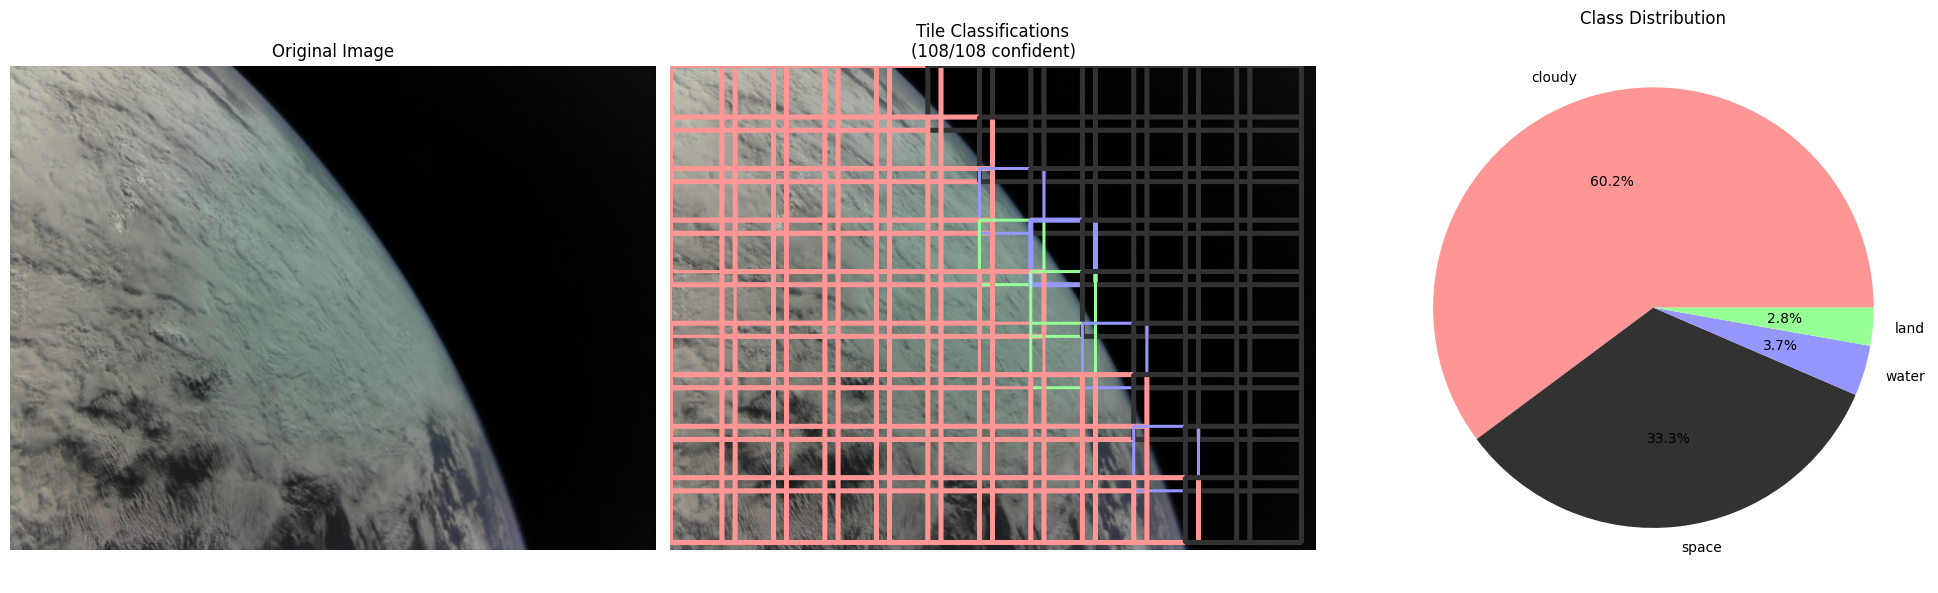

In [5]:
custom_image_path = "ER_Earth_41/B4_ER_IMG_87.jpg"
results, confidence, image_type = test_large_image(
    image_path=custom_image_path,
    tile_size=64,                    # Size of each tile (64x64 pixels)
    overlap=0.2,                     # 20% overlap between tiles
    confidence_threshold=0.5,        # Only count tiles with >50% confidence
    model_path='image_classifier_64x64.pth',  # Path to your trained model
    visualize=True,                   # Show visualization plots
    darkness_threshold=30,
)
